In [1]:
library(tidyverse)
library(tidymodels)

Warning message:
“package ‘ggplot2’ was built under R version 4.3.2”
── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.5.0     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.5     ✔ rsample      1.2.0
✔ dials        1.2.0     ✔ tune         1.1.2
✔ infer        1.0.5     ✔ workflows    1.1.3
✔ modeldata    1.2.0     ✔ workflowsets 1.0.1
✔ parsnip      1.1.1     ✔ yardstick    1.2.0
✔ recipes      1.0.8     

── Conflicts ───────────────────────────────────────── tidymodels_co

In [2]:
url <- "https://raw.githubusercontent.com/Stev-hu/Dsci-100-group-project/main/atp2017-2019.csv"
download.file(url, "tennis_data.csv")

In [3]:
set.seed(8888)

In [4]:
#read in csv file and select rows
tennis_data <- read_csv("tennis_data.csv") |>
            select(winner_ht, loser_ht, w_df, l_df)

#combine columns into winners and losers
winner_data <- tennis_data |>
        select(winner_ht, w_df) |>
        mutate(outcome = "W") |>
        rename(ht = winner_ht, df = w_df)

loser_data <- tennis_data |> 
        select(loser_ht, l_df) |>
        mutate(outcome = "L") |>
        rename(ht = loser_ht, df = l_df)

#bind all the rows together and remove NAs
tennis <- bind_rows(winner_data, loser_data) |> 
        mutate(outcome = as_factor(outcome)) |>
        na.omit()

New names:
• `` -> `...1`
Rows: 6866 Columns: 50
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (16): tourney_id, tourney_name, surface, tourney_level, winner_seed, win...
dbl (34): ...1, draw_size, tourney_date, match_num, winner_id, winner_ht, wi...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
# centering and scaling the tennis data
tennis_recipe <- recipe(outcome ~ ht + df, data = tennis) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors()) |>
        prep()
scaled_tennis <- bake(tennis_recipe, tennis)

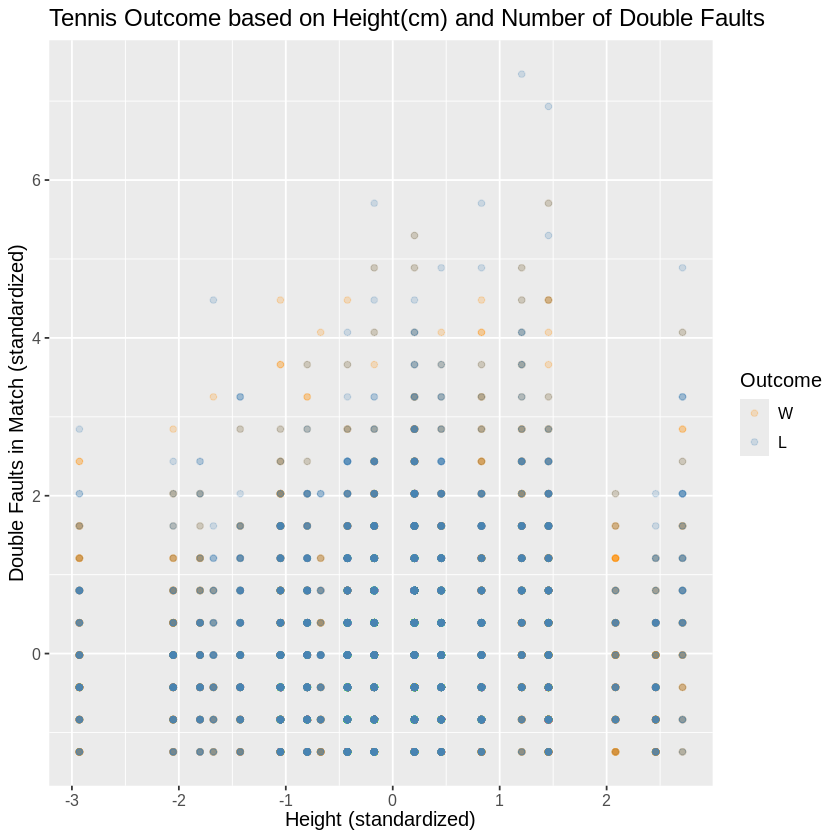

In [6]:
# display a plot of the scaled tennis data in a scatter plot to help visualize it
scaled_height_df <- scaled_tennis |>
        ggplot(aes(x = ht, y = df, color = outcome)) +
        geom_point(alpha = 0.2) +
        labs(x = "Height (standardized)", y = "Double Faults in Match (standardized)", color = "Outcome") +
        ggtitle("Tennis Outcome based on Height(cm) and Number of Double Faults") +
        scale_color_manual(values = c("darkorange", "steelblue")) +
        theme(text = element_text(size = 12))
scaled_height_df

In [7]:
# split data to create training and testing data sets
tennis_split <- initial_split(tennis, prop = 0.75, strata = outcome)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

In [8]:
# from comparison v = 5 was found to be more accurate than v = 10
tennis_vfold <- vfold_cv(tennis_train, v = 5, strata = outcome)

# new recipe and workflow using training data
tennis_train_recipe <- recipe(outcome ~ ht + df, data = tennis_train) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors())

# set an arbitrary number of neighbors for now
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 5) |>
        set_engine("kknn") |>
        set_mode("classification")

knn_fit <- workflow() |>
        add_recipe(tennis_train_recipe) |>
        add_model(knn_spec) |>
        fit_resamples(resamples = tennis_vfold) |>
        collect_metrics()
knn_fit

.metric  .estimator mean      n std_err     .config             
1 accuracy binary     0.4701835 5 0.002267951 Preprocessor1_Model1
2 roc_auc  binary     0.4970133 5 0.004039847 Preprocessor1_Model1

neighbors .metric  .estimator mean      n std_err     .config              
1    1       accuracy binary     0.4738532 5 0.001536678 Preprocessor1_Model01
2   51       accuracy binary     0.5103976 5 0.003337749 Preprocessor1_Model02
3  101       accuracy binary     0.5411315 5 0.006156215 Preprocessor1_Model03
4  151       accuracy binary     0.5659021 5 0.006189356 Preprocessor1_Model04
5  201       accuracy binary     0.5666667 5 0.003637730 Preprocessor1_Model05
6  251       accuracy binary     0.5715596 5 0.004559037 Preprocessor1_Model06
7  301       accuracy binary     0.5662080 5 0.003407076 Preprocessor1_Model07
8  351       accuracy binary     0.5669725 5 0.003311377 Preprocessor1_Model08
9  401       accuracy binary     0.5675841 5 0.002275669 Preprocessor1_Model09
10 451       accuracy binary     0.5730887 5 0.003275885 Preprocessor1_Model10
11 501       accuracy binary     0.5733945 5 0.003920759 Preprocessor1_Model11

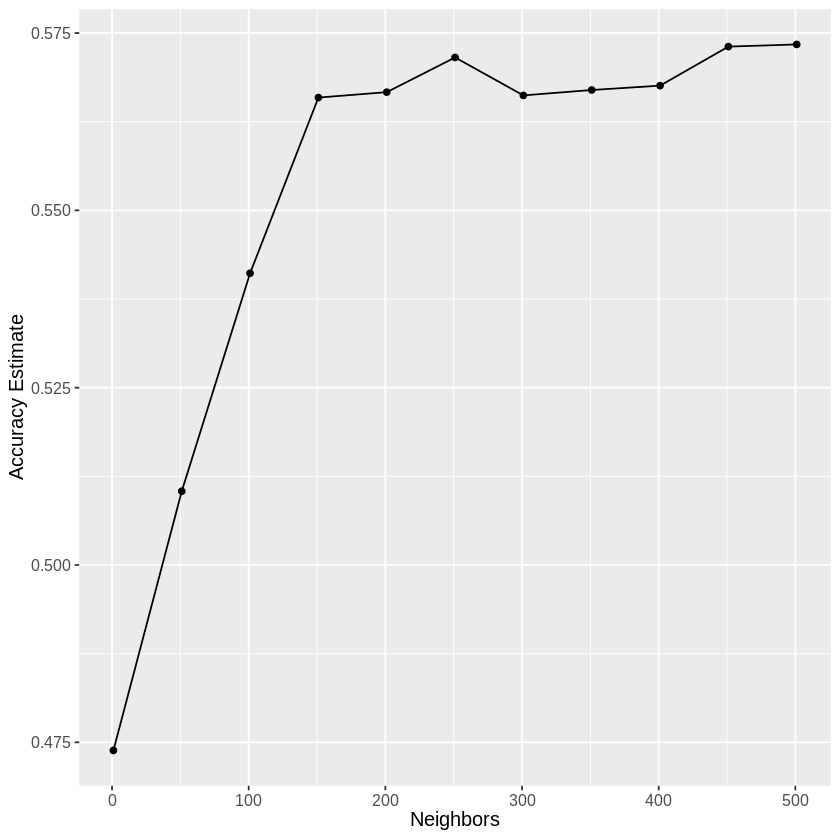

In [9]:
# Tuning engine to find the ideal number of k nearest neighbors. 
# We display the results on a chart with neighbors and accuracy

knn_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
        set_engine("kknn") |>
        set_mode("classification")

k_vals <- tibble(neighbors = seq(from = 1, to = 501, by = 50))

knn_results <- workflow() |>
        add_recipe(tennis_train_recipe) |>
        add_model(knn_tune) |>
        tune_grid(resamples = tennis_vfold, grid = k_vals) |>
        collect_metrics()

accuracies <- knn_results |>
        filter(.metric == "accuracy")
accuracies

accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
        geom_point() +
        geom_line() +
        labs(x = "Neighbors", y = "Accuracy Estimate") +
        theme(text = element_text(size = 12))
accuracy_vs_k

From the chart, we can see that there is a steep increase in accuracy when increasing the number of neighbors from 1 up to 200 where the accuracy plateaus there increasing only marginally. To minimize overfitting of the data, we set the number of neighbors at 200.

In [10]:
# using the recipe from the original tennis data
tennis_recipe <- recipe(outcome ~ ht + df, data = tennis) |>
        step_scale(all_predictors()) |>
        step_center(all_predictors()) |>
        prep()

# setting number of neighbors based on predicted accuracies from tuning
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 200) |>
        set_engine("kknn") |>
        set_mode("classification")

# workflow to put it all together
knn_fit <- workflow() |>
        add_recipe(tennis_recipe) |>
        add_model(knn_spec) |>
        fit(data = tennis_train)

In [11]:
# create a tibble with predicted outcomes and actual outcomes
tennis_test_predictions <- predict(knn_fit, tennis_test) |>
        bind_cols(tennis_test)
tennis_test_predictions

.pred_class ht  df outcome
1    L           188  3 W      
2    L           188  2 W      
3    W           183  0 W      
4    L           180  2 W      
5    L           175  3 W      
6    W           203  6 W      
7    L           196  6 W      
8    L           178  5 W      
9    W           208  2 W      
10   W           196  3 W      
11   L           178  2 W      
12   W           185  0 W      
13   W           208  1 W      
14   L           190  6 W      
15   L           188  7 W      
16   L           178  4 W      
17   L           190  1 W      
18   L           183  2 W      
19   W           163  3 W      
20   L           188  3 W      
21   W           208  5 W      
22   L           188  8 W      
23   W           196  1 W      
24   W           183  0 W      
25   L           183  3 W      
26   W           193  0 W      
27   W           185  2 W      
28   W           203  5 W      
29   L           180 11 W      
30   L           188 11 W      
⋮    ⋮           ⋮   ⋮  ⋮      
2151 W           208 4  L      
2152 L           183 1  L      
2153 W           181 0  L      
2154 W           185 3  L      
2155 W           188 0  L      
2156 W           185 0  L      
2157 W           198 1  L      
2158 L           185 4  L      
2159 L           196 7  L      
2160 L           180 4  L      
2161 W           208 5  L      
2162 L           185 6  L      
2163 L           178 2  L      
2164 L           175 7  L      
2165 W           185 0  L      
2166 L           190 1  L      
2167 L           188 2  L      
2168 L           188 3  L      
2169 W           178 1  L      
2170 L           183 3  L      
2171 L           183 6  L      
2172 L           183 2  L      
2173 W           198 6  L      
2174 L           188 5  L      
2175 W           188 1  L      
2176 L           185 5  L      
2177 W           198 4  L      
2178 L           188 4  L      
2179 W           198 2  L      
2180 W           188 1  L

In [12]:
# find the accuracy of these predictions to estimate the accuracy of the overall model
prediction_accuracy <- tennis_test_predictions |>
        metrics(truth = outcome, estimate = .pred_class) |>
        filter(.metric == "accuracy")
# find the precision
prediction_precision <- tennis_test_predictions |>
        precision(truth = outcome, estimate = .pred_class, event_level = "first")
prediction_precision

.metric   .estimator .estimate
1 precision binary     0.6333699

In [13]:
# confusion matrix to preview distribution of false positives/negatives
confusion <- tennis_test_predictions |>
        conf_mat(truth = outcome, estimate = .pred_class)
confusion

          Truth
Prediction   W   L
         W 577 334
         L 578 691

In [14]:
# KNN model and setting neighbors based on predicted accuracies neighbors
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 200) |>
        set_engine("kknn") |>
        set_mode("classification")

# final workflow
knn_fit <- workflow() |>
        add_recipe(tennis_recipe) |>
        add_model(knn_spec) |>
        fit(data = tennis_train)

Here we are finally ready to use this completed model. We can input a input a height (ht) and number of double faults (df) to predict if they will win or lose

In [16]:
new_observation <- tibble(ht = 185, df = 1)

prediction <- predict(knn_fit, new_observation)
prediction

.pred_class
1 W